# Assignment
### Dependencies
Using Python 3.7

    pip install ipython
    pip install pandas
    pip install matplotlib
    pip install -U scikit-learn
    pip install jupyter notebook
    
### Import functions

In [45]:
from tools.helpers import read_json, pandas_keep_columns, retrieve_data, create_project_workspace
from assignment import setup_workspace_retrieve_data, clean_data, select_historic_data
from assignment import annualized_rate_of_return, logistic_regression
from assignment import plot_hist_for_numeric_col, pie_chart, get_defaults
from assignment import get_best_distribution
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import importlib
plt.rcParams['figure.figsize'] = [15, 5]
%matplotlib inline

In [19]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
from matplotlib import pyplot as plt
plt.style.use('ggplot')

### Read Project Configuration file
This contains download link, file names and columns to use. 

In [12]:
data = read_json('data/project_config.json')
steps = data['steps']

# Part 1 Data Exploration and Evaluation
- [x] Clean columns, carry forward
`['loan_amnt’, 'funded_amnt’, 'term’, 'int_rate’, 'grade’, 'annual_inc’, 'issue_d’, 'dti’, 'revol_bal’, 'total_pymnt’, 'loan_status’]`

- [x] Perform any necessary cleaning and aggregations to explore and better
  understand the dataset.
  - [x] Describe the `data.describe()`

- [x] Describe any assumptions you made to handle null variables and outliers.
    - [x] Remove outliers for Annual Income
    - [x] Remove outliers for DTI
    - [x] Total credit revolving balance (revol_bal)

- [x] Describe the distributions of the features.
    - [x] Include two data visualizations and 
    - [x] Two summary statistics to support these findings.

In [13]:
df = setup_workspace_retrieve_data(data)

    downloading data.
    unzipping data.
    unzipping data complete.


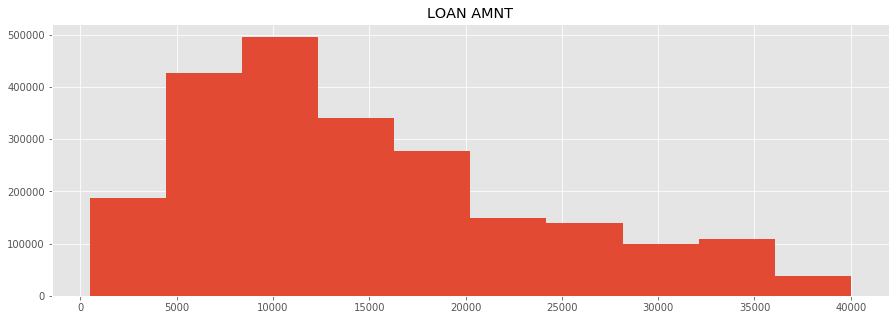

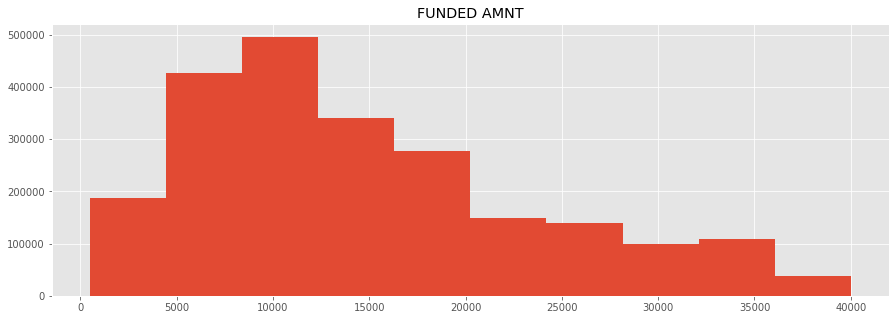

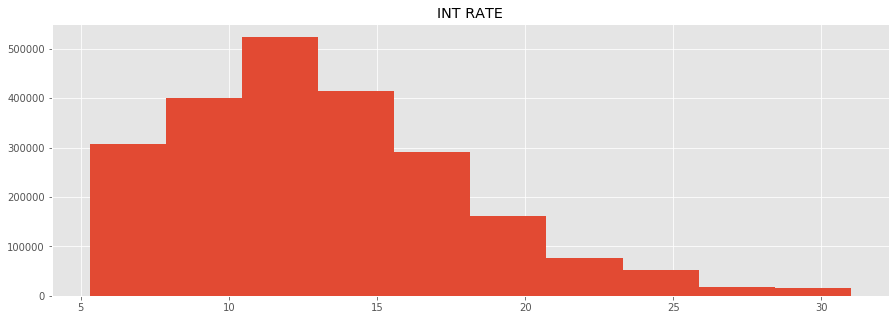

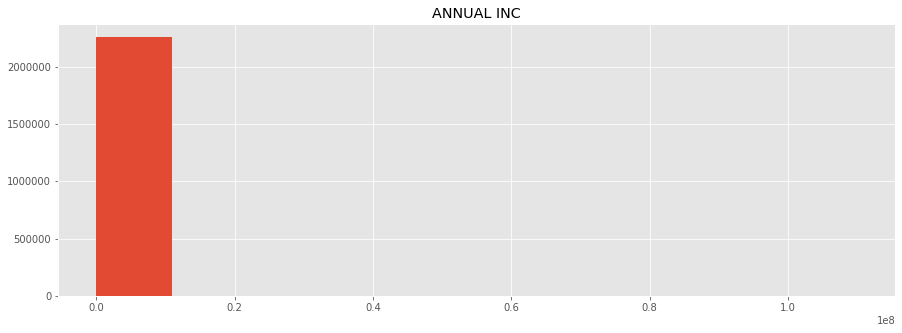

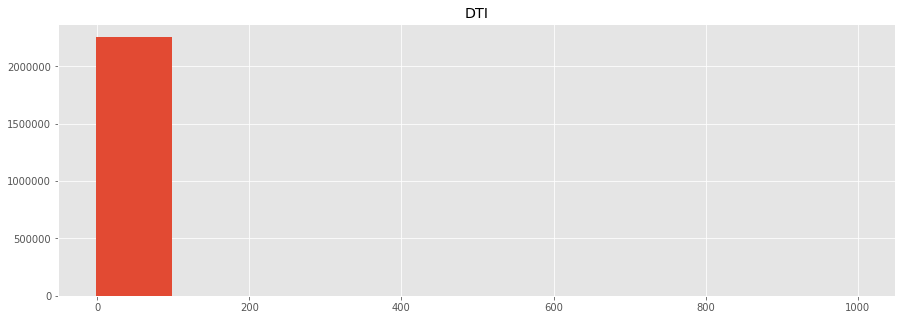

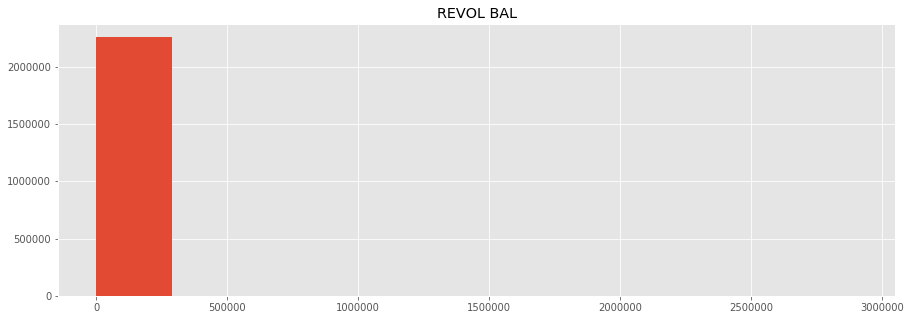

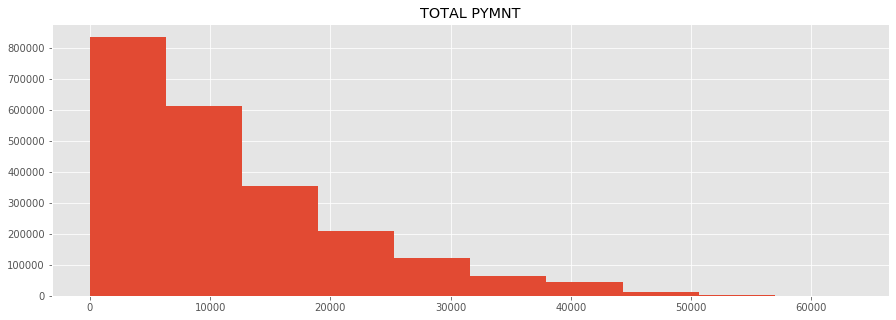

In [14]:
plot_hist_for_numeric_col(df, df.columns, '01_before_filter')

In [15]:
dfc = clean_data(df)

    creating value-added fields for data.
    filtering fields for data.
    pre-filter length: 2260668 post-filter length: 2213821 dif. of: 46847 dif. of: 2.07%


### Outliers
Three columns have outliers in the distribution:
* **Annual Income**
* **DTI**
* **Total credit revolving balance**

Rows with >= 3 or <= -3 Z-score were removed. The following are the filtered histograms:

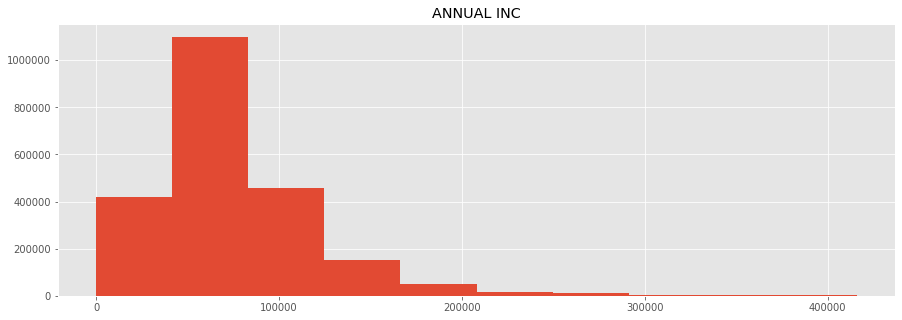

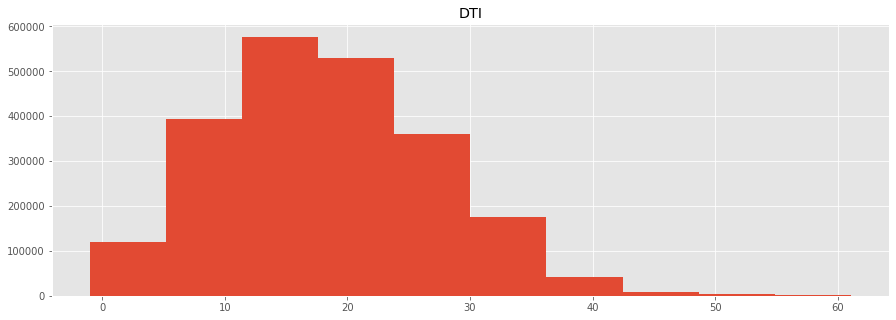

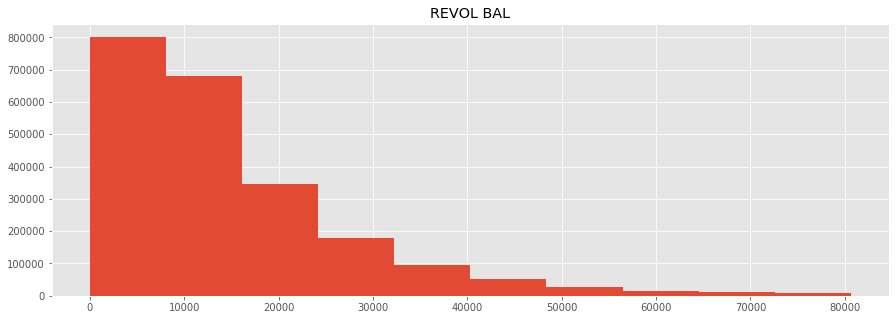

In [16]:
plot_hist_for_numeric_col(dfc, ['annual_inc', 'dti', 'revol_bal'], '02_post_filter')

## Data descriptive statistics

In [24]:
pd.options.display.float_format = '{:,.2f}'.format

dfc.describe()

,loan_amnt,funded_amnt,int_rate,annual_inc,dti,revol_bal,total_pymnt,issue_year,issue_month,months,default,annualized_rate_return,z_score_annual_inc,z_score_revol_bal,z_score_dti
count,"2,213,821.00","2,213,821.00","2,213,821.00","2,213,821.00","2,213,821.00","2,213,821.00","2,213,821.00","2,213,821.00","2,213,821.00","2,213,821.00","2,213,821.00","2,213,821.00","2,213,821.00","2,213,821.00","2,213,821.00"
mean,"14,872.42","14,867.24",13.11,"75,085.37",18.42,"14,734.99","11,723.18","2,015.85",6.75,30.65,0.54,-0.11,-0.03,-0.08,-0.03
std,"9,074.88","9,072.98",4.83,"43,695.79",8.86,"12,727.95","9,790.93",1.79,3.41,21.62,0.50,0.20,0.39,0.59,0.63
min,500.00,500.00,5.31,0.00,-1.00,0.00,0.00,"2,007.00",1.00,0.00,0.00,-1.00,-0.69,-0.77,-1.41
25%,"8,000.00","8,000.00",9.49,"46,000.00",11.86,"5,874.00","4,252.91","2,015.00",4.00,12.00,0.00,-0.25,-0.28,-0.50,-0.49
50%,"12,500.00","12,500.00",12.62,"65,000.00",17.77,"11,125.00","9,008.95","2,016.00",7.00,29.00,1.00,0.00,-0.12,-0.25,-0.07
75%,"20,000.00","20,000.00",15.99,"91,000.00",24.37,"19,626.00","16,568.51","2,017.00",10.00,44.00,1.00,0.04,0.12,0.15,0.40
max,"40,000.00","40,000.00",30.99,"416,000.00",61.06,"80,639.00","63,296.88","2,018.00",12.00,138.00,1.00,0.29,3.00,3.00,3.00


## Discussion

1. *Describe any assumptions you made to handle null variables and outliers.* 
    
    * For outlier variables, I removed anything with a value of >= 3 or <= -3 Z-score. I didn't drop  rows with null values.
    
    
2. *Describe the distributions of the features.*

    * Some of the variables have distributions that appear in the family of either Normal, Poisson, Exponential or Binomial. For those with clear outliers, they were filtered as mentioned above. Issue Month - parsed from `issue_d` though for example, appears more Uniform.




# Part 2 Business Analysis
- [x] Assume a 36 month investment period for each loan, and exclude loans with less than 36 months of data available.

- [x] What percentage of loans has been fully paid?

In [36]:
dfs, pct_filtered_fully_paid = select_historic_data(dfc)
print('{:.2f}% of loans Fully Paid excluding < 36 months'.format(pct_filtered_fully_paid * 100))


75.61% of loans Fully Paid excluding < 36 months


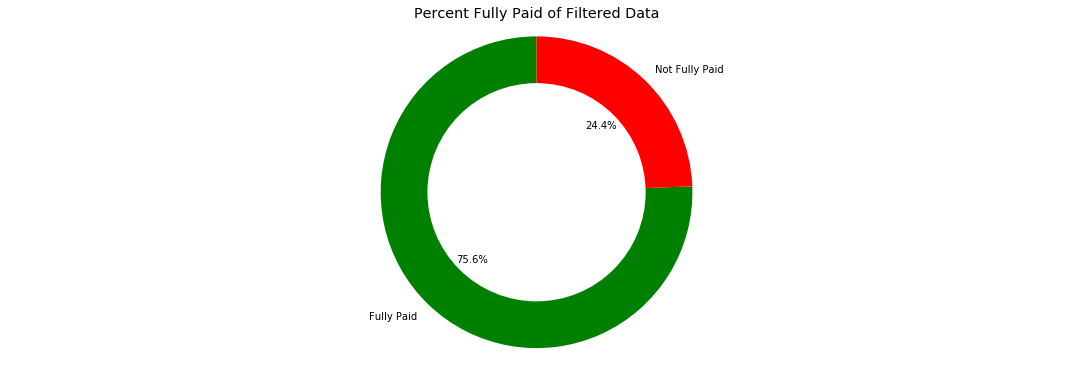

In [43]:
pie_chart(
    [pct_filtered_fully_paid * 100, 100 - (pct_filtered_fully_paid * 100)], 
    ['Fully Paid', 'Not Fully Paid'],
    ['green', 'red'],
    'Percent Fully Paid of Filtered Data'
)

- [x] When bucketed by year of origination and grade, which cohort has the highest rate of defaults? Here you may assume that any loan which was not fully paid had “defaulted”.


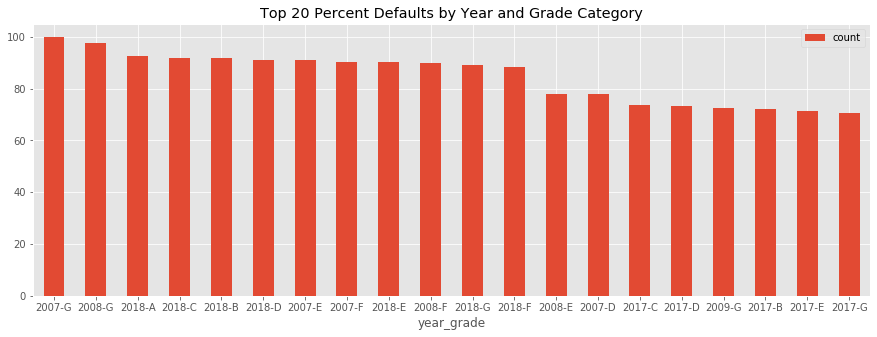

In [47]:
get_defaults(df)

- [x] When bucketed by year of origination and grade, what annualized rate of return have these loans generated on average?
      
    * For simplicity, use the following approximation:
      `Annualized rate of return = (total_pymnt / funded_amnt) ^ (1/3) - 1`


# Part 3 Modeling
- [ ] Build a logistic regression model to predict loan defaults

- [ ] Assume that

    - [ ] (i) You are given the ability to invest in each loan independently
    
    - [ ] (ii) You invest immediately following loan origination and hold to maturity (36 months)
    
    - [ ] (iii) All loan fields that would be known upon origination are made available to you.

- [ ] Was the model effective? 
    - [ ] Explain how you validated your model and describe how you measure the performance of the model.
    
    

    creating annualized rate of return.


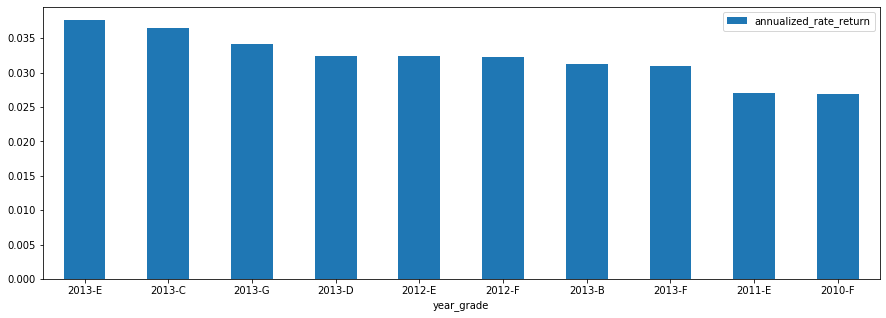

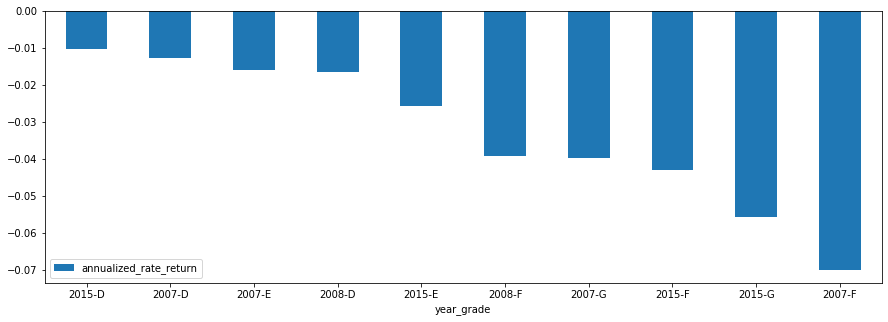

In [4]:
annualized_rate_of_return(df)

    Accuracy of logistic regression on test: 92.36%
    Confusion Matrix Plot
[[297403   9776]
 [ 40964 316004]]
    Classification Report
              precision    recall  f1-score   support

           0       0.88      0.97      0.92    307179
           1       0.97      0.89      0.93    356968

    accuracy                           0.92    664147
   macro avg       0.92      0.93      0.92    664147
weighted avg       0.93      0.92      0.92    664147



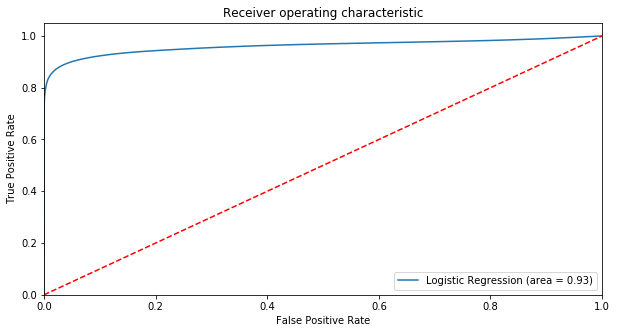

In [5]:
logistic_regression(df)